# Analyse ROMY Events - Barometer

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
# import multitaper

from obspy.clients.fdsn import Client
from twistpy.tilt.correction import remove_tilt

In [2]:
from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill
from functions.compute_backazimuth import __compute_backazimuth
from functions.makeplot_waveform_comparison_cc import __makeplot_waveform_comparison_cc
from functions.makeplot_comparison_ccf import __makeplot_comparison_ccf
from functions.get_event_info import __get_event_info
from functions.compute_cross_wavelet_transform import __compute_cross_wavelet_transform
from functions.compute_cwt import __compute_cwt
from functions.makeplot_waveforms import __makeplot_waveforms

In [ ]:
%matplotlib tk

In [13]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [311]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"romy_events/figures/"

## path to data archive
config['path_to_data'] = data_path+"romy_events/data/"

## select seismometer ( FUR or DROMY )
config['seis'] = "DROMY"

## Event
config['event_name'] = "Wind"
config['tbeg'] = obs.UTCDateTime("2024-03-04 00:00")
config['tend'] = obs.UTCDateTime("2024-03-05 00:00")
config['trim'] = [5*3600, 14*3600]

# config['event_name'] = "Wind"
# config['tbeg'] = obs.UTCDateTime("2024-04-19 00:00")
# config['tend'] = obs.UTCDateTime("2024-04-20 00:00")
# config['trim'] = [10*3600, 12*3600]



config['filename'] = f"ROMY_{config['seis']}_{config['event_name']}_{str(config['tbeg'].date).replace('-','')}_6C.mseed"


## ROMY coordinates
config['sta_lon'] = 11.275501
config['sta_lat'] = 48.162941



## Load Data

In [303]:
# config, dist, baz, az = __get_event_info(config)

In [304]:
st0 = obs.read(config['path_to_data']+config['filename'])

st0


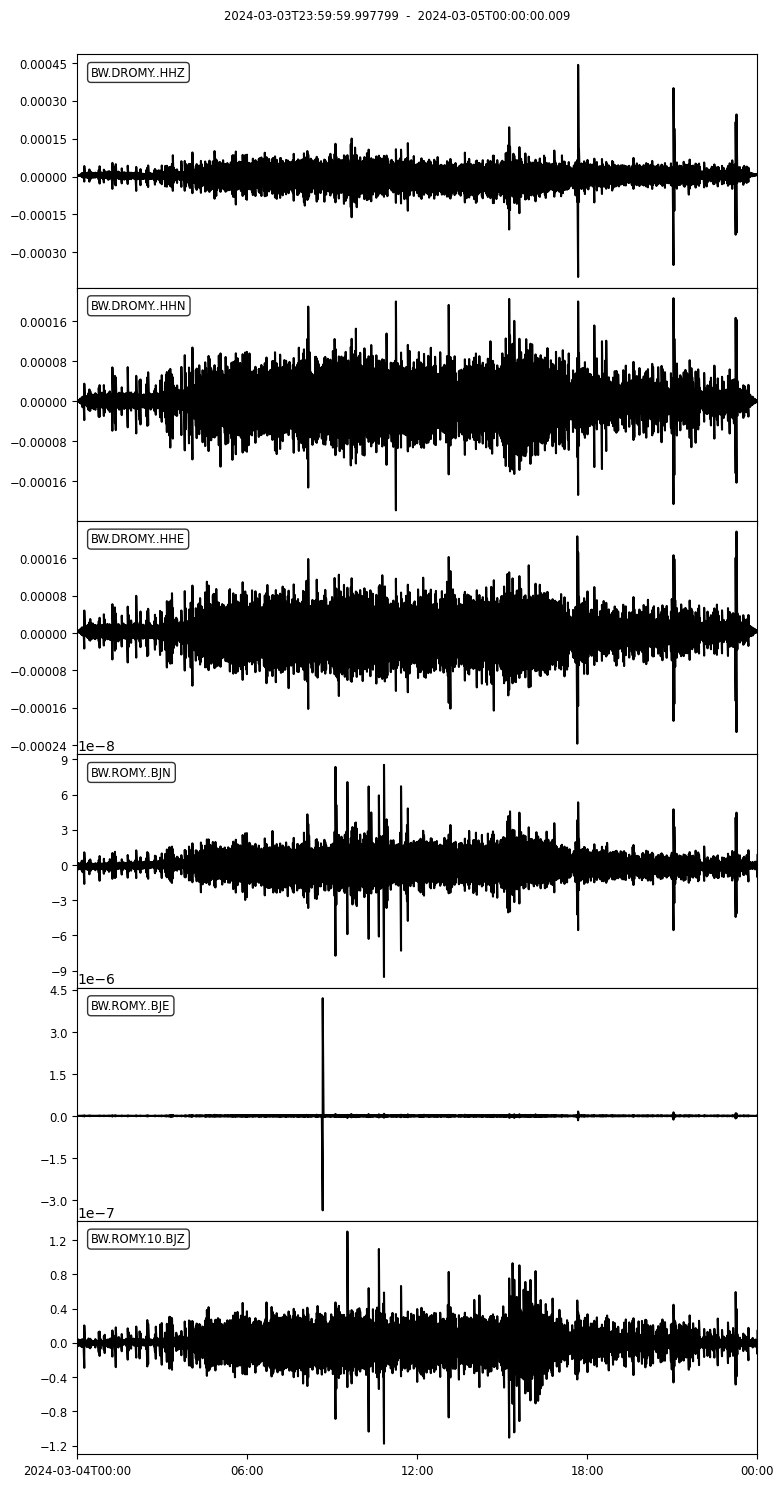

In [305]:
st0.plot(equal_scale=False);

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


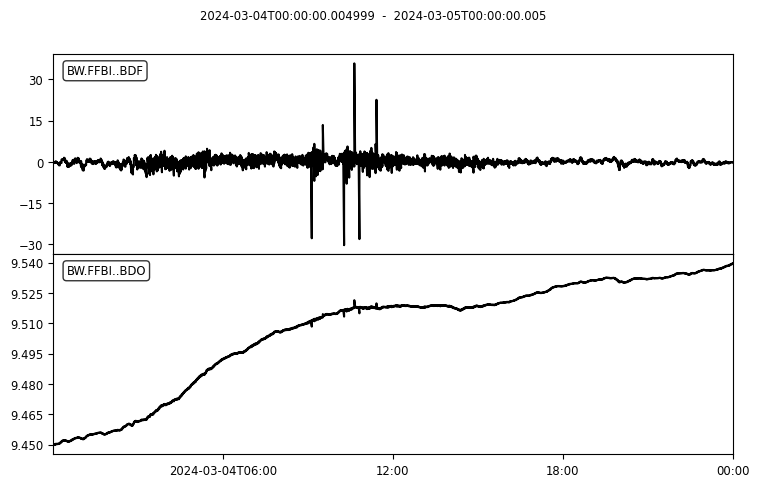

In [330]:
from obspy import read_inventory
from andbro__read_sds import __read_sds

ffbi0 = __read_sds(bay_path+"mseed_online/archive/", "BW.FFBI..BDF", config['tbeg'], config['tend'])

if len(ffbi0) != 2:
    ffbi0.merge();

ffbi_inv = read_inventory(root_path+"/Documents/ROMY/ROMY_infrasound/station_BW_FFBI.xml")


ffbi0 += __read_sds(bay_path+"mseed_online/archive/", "BW.FFBI..BDO", config['tbeg'], config['tend'])
for tr in ffbi0:
    if "F" in tr.stats.channel:
        tr = tr.remove_response(ffbi_inv, water_level=10)

    if "O" in tr.stats.channel:
        # tr.data = tr.data /1.0 /6.28099e5 /100e-3   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 100 mV/hPa
        tr.data = tr.data /1.0 /6.28099e5 /1e-5   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 100 mV/hPa

# ffbi0 = ffbi0.resample(1.0, no_filter=True)

ffbi0.merge()

# ffbi0 = ffbi0.trim(config['tbeg']+config['trim'][0], config['tend']-config['trim'][1])


ffbi0.plot(equal_scale=False);

In [519]:
for tr in ffbi0:
    if "O" in tr.stats.channel:
        tr.data *= 1e4

In [569]:
rot1 = st0.select(station=f"ROMY", channel="*J*").copy()

acc1 = st0.select(station=f"{config['seis']}*", channel="*H*").copy()

til1 = rot1.integrate("spline")


stt = obs.Stream()

stt += til1.copy()
stt += ffbi0.copy()

stt = stt.resample(10.0, no_filter=False)
stt = stt.resample(1.0, no_filter=False)

stt

5 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2024-03-04T00:00:00.004200Z - 2024-03-04T23:59:59.004200Z | 1.0 Hz, 86400 samples
BW.ROMY..BJN   | 2024-03-04T00:00:00.009000Z - 2024-03-04T23:59:59.009000Z | 1.0 Hz, 86400 samples
BW.ROMY..BJE   | 2024-03-03T23:59:59.997799Z - 2024-03-04T23:59:58.997799Z | 1.0 Hz, 86400 samples
BW.FFBI..BDF   | 2024-03-04T00:00:00.004999Z - 2024-03-04T23:59:59.004999Z | 1.0 Hz, 86400 samples
BW.FFBI..BDO   | 2024-03-04T00:00:00.005000Z - 2024-03-04T23:59:59.005000Z | 1.0 Hz, 86400 samples

In [589]:
# fmin, fmax = 0.001, 0.01
fmin, fmax = 0.001, 0.005

stt = stt.detrend("linear")
stt = stt.detrend("demean")

stt = stt.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);

stt = stt.trim(config['tbeg']+5*3600, config['tbeg']+7*3600)

for tr in til1:
    tr.data = tr.data[:-1]


stt.plot(equal_scale=False);


In [590]:
def __makeplot():

    from scipy.signal import hilbert
    from numpy import imag

    Nrow, Ncol = 5, 1

    yscale = 1e9

    font = 12

    ch = "O"

    tscale, tunit = 1/3600, "hours"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 12))

    ax[0].plot(stt.select(component="Z")[0].times(reftime=config['tbeg'])*tscale,
               stt.select(component="Z")[0].data*yscale,
               label="ROMY-Z", color="tab:blue")

    ax[1].plot(stt.select(component="N")[0].times(reftime=config['tbeg'])*tscale,
               stt.select(component="N")[0].data*yscale,
               label="ROMY-N", color="tab:orange")

    ax[2].plot(stt.select(component="E")[0].times(reftime=config['tbeg'])*tscale,
               stt.select(component="E")[0].data*yscale,
               label="ROMY-E", color="tab:red")

    ax[3].plot(stt.select(component=ch)[0].times(reftime=config['tbeg'])*tscale,
               stt.select(component=ch)[0].data,
               label=f"FFBI-{ch}", color="k")

    ax[4].plot(stt.select(component=ch)[0].times(reftime=config['tbeg'])*tscale,
               imag(hilbert(stt.select(component=ch)[0].data)),
               label=f"hilbert(FFBI-{ch})", color="darkgrey")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylabel("Tilt (nrad)", fontsize=font)
    ax[1].set_ylabel("Tilt (nrad)", fontsize=font)
    ax[2].set_ylabel("Tilt (nrad)", fontsize=font)

    ax[3].set_ylabel("Pressure (Pa)", fontsize=font)
    ax[4].set_ylabel("Pressure (Pa)", fontsize=font)

    ax[Nrow-1].set_xlabel(f"Time ({tunit}) from {config['tbeg']}", fontsize=font)

    ax[0].set_title(f"{fmin} - {fmax} Hz")

    plt.show();
    return fig


fig = __makeplot();

fig.savefig("/home/andbro/Desktop/FürRuedi/"+"waveforms.png")


In [591]:
def __makeplot():

    from scipy.signal import hilbert
    from numpy import imag

    Nrow, Ncol = 2, 2

    ch = "O"

    font = 12

    yscale = 1e9

    tscale, tunit = 1/3600, "hours"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0, 0].scatter(imag(hilbert(stt.select(component=ch)[0].data)),
                    stt.select(component="N")[0].data*yscale,
                    label="ROMY-N", color="tab:orange", s=5
                    )
    ax[0, 0].set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax[0, 0].set_ylabel("Tilt (nrad)", fontsize=font)

    ax[0, 1].scatter(stt.select(component=ch)[0].data,
                    stt.select(component="N")[0].data*yscale,
                    label="ROMY-N", color="tab:orange", s=5,
                    )
    ax[0, 1].set_xlabel("Pressure (Pa)", fontsize=font)
    ax[0, 1].set_ylabel("Tilt (nrad)", fontsize=font)

    ax[1, 0].scatter(imag(hilbert(stt.select(component=ch)[0].data)),
                    stt.select(component="E")[0].data*yscale,
                    label="ROMY-E", color="tab:red", s=5
                    )
    ax[1, 0].set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax[1, 0].set_ylabel("Tilt (nrad)", fontsize=font)

    ax[1, 1].scatter(stt.select(component=ch)[0].data,
                    stt.select(component="E")[0].data*yscale,
                    label="ROMY-E", color="tab:red", s=5
                    )
    ax[1, 1].set_xlabel("Pressure (Pa)", fontsize=font)
    ax[1, 1].set_ylabel("Tilt (nrad)", fontsize=font)

    for j in range(2):
        for i in range(2):
            ax[i, j].grid(ls=":", zorder=0)
            ax[i, j].legend(loc=1)
            # ax[i, j].set_title(f"{fmin} - {fmax} Hz", fontsize=font)

    plt.show();
    return fig

# fig = __makeplot();

# fig.savefig("/home/andbro/Desktop/FürRuedi/"+"waveforms_scatter.png")

In [592]:
def __compare_tilt_pressure(st0):

    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import nan_to_num, arange, array, linspace, imag, roll
    from matplotlib.gridspec import GridSpec
    from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from functions.smoothing import __smooth
    from scipy.signal import hilbert

    tlp = st0.copy()

    dt = tlp[0].stats.delta

    times = tlp[0].times()/3600

    ch = "O"

    arr0 = tlp.select(component=ch)[0].data
    arr1 = tlp.select(component="N")[0].data
    arr2 = tlp.select(component="E")[0].data


    Nshift = len(arr0)

    ccf1 = correlate(arr0, arr1, shift=Nshift, demean=False, normalize='naive', method='fft')
    ccf2 = correlate(arr0, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

    cclags = arange(-Nshift, Nshift+1) * dt

    shift1, value1 = xcorr_max(ccf1)
    shift2, value2 = xcorr_max(ccf2)

    arr1_shifted = roll(arr1, shift1)
    arr2_shifted = roll(arr2, shift2)

    print("Nshift: ", shift1, "Tshift: ", shift1*dt, "CC: ", value1)
    print("Nshift: ", shift2, "Tshift: ", shift2*dt, "CC: ", value2)


    b1, a1 = __compute_orthogonal_distance_regression(arr0, arr1, xerr=None, yerr=None, bx=None, by=None)
    b2, a2 = __compute_orthogonal_distance_regression(arr0, arr2, xerr=None, yerr=None, bx=None, by=None)

    b1_shifted, a1_shifted = __compute_orthogonal_distance_regression(arr0, arr1_shifted, xerr=None, yerr=None, bx=None, by=None)
    b2_shifted, a2_shifted = __compute_orthogonal_distance_regression(arr0, arr2_shifted, xerr=None, yerr=None, bx=None, by=None)

    xxx = linspace(arr0.min(), arr0.max(), 100)

    Nrow, Ncol = 5, 2
    font = 12

    fig = plt.figure(figsize=(12, 10))

    gs0 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.5)

    ax1 = fig.add_subplot(gs0[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :1])
    ax4 = fig.add_subplot(gs[2, 1:])
    ax5 = fig.add_subplot(gs[3, :1])
    ax6 = fig.add_subplot(gs[3, 1:])
    ax7 = fig.add_subplot(gs[4, :1])
    ax8 = fig.add_subplot(gs[4, 1:])

    plt.subplots_adjust(hspace=0.35)

    ax1.plot(times, arr0, color="black", label=f"FFBI.BD{ch}")
    ax1.set_ylabel("Pressure (Pa)", fontsize=font)
    ax1.get_xaxis().set_visible(False)
    ax1.legend(loc=1)

    ax2.plot(times, arr1*1e9, label="N")
    ax2.plot(times, arr2*1e9, label="E")
    ax2.legend(ncol=2)
    ax2.set_ylabel("Tilt (nrad)", fontsize=font)
    ax2.set_xlabel("Time (hours)", fontsize=font, labelpad=1)


    ax3.scatter(arr0, arr1*1e9, color="tab:blue", s=1)
    ax3.plot(xxx, (a1+b1*xxx)*1e9, ls="--", color="k", label=f"a={a1*1e9:.2f}; b={b1*1e9:.2f}")
    ax3.set_xlabel("Pressure (Pa)", fontsize=font)
    ax3.set_ylabel("Tilt (nrad)", fontsize=font)
    ax3.legend()

    ax4.scatter(arr0, arr2*1e9, color="tab:orange", s=1)
    ax4.plot(xxx, (a2+b2*xxx)*1e9, ls="--", color="k", label=f"a={a2*1e9:.2f}; b={b2*1e9:.2f}")
    ax4.set_xlabel("Pressure (Pa)", fontsize=font)
    ax4.set_ylabel("Tilt (nrad)", fontsize=font)
    ax4.legend()

    ll = f"t={round(shift1*dt, 1)} s  CC={round(value1, 1)}"
    ax5.plot(cclags, ccf1, color="tab:blue", label=ll)
    ax5.set_ylabel("CC-Coeff.", fontsize=font)
    ax5.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax5.set_ylim(-1, 1)
    ax5.axvline(shift1*dt, -1, 1, color="k", ls="--", zorder=0)
    ax5.scatter(shift1*dt, value1, color="k", marker="d", zorder=0)
    ax5.legend()
    # ax5.text(.005, .97, ll, ha='left', va='top', transform=ax3.transAxes, fontsize=font)

    ll = f"t={round(shift2*dt, 1)} s  CC={round(value2, 1)}"
    ax6.plot(cclags, ccf2, color="tab:orange", label=ll)
    ax6.set_ylabel("CC-Coeff.", fontsize=font)
    ax6.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax6.set_ylim(-1, 1)
    ax6.axvline(shift2*dt, -1, 1, color="k", ls="--", zorder=0)
    ax6.scatter(shift2*dt, value2, color="k", marker="d", zorder=0)
    ax6.legend()
    # ax6.text(.005, .97, ll, ha='left', va='top', transform=ax4.transAxes, fontsize=font)


    ax7.scatter(arr0, arr1_shifted*1e9, color="tab:blue", s=1)
    ax7.plot(xxx, (a1_shifted+b1_shifted*xxx)*1e9, ls="--", color="k", label=f"a={a1_shifted*1e9:.2f}; b={b1_shifted*1e9:.2f}")
    ax7.set_xlabel("Pressure (Pa)", fontsize=font)
    ax7.set_ylabel("Tilt (nrad)", fontsize=font)
    ax7.legend()

    ax8.scatter(arr0, arr2_shifted*1e9, color="tab:orange", s=1)
    ax8.plot(xxx, (a2_shifted+b2_shifted*xxx)*1e9, ls="--", color="k", label=f"a={a2_shifted*1e9:.2f}; b={b2_shifted*1e9:.2f}")
    ax8.set_xlabel("Pressure (Pa)", fontsize=font)
    ax8.set_ylabel("Tilt (nrad)", fontsize=font)
    ax8.legend()

    for ax in [ax3, ax4, ax5, ax6, ax7, ax8]:
        ax.grid(ls=":", alpha=0.5, zorder=0, color="grey")

    plt.show();
    return fig

fig = __compare_tilt_pressure(stt)

fig.savefig("/home/andbro/Desktop/FürRuedi/"+"waveforms_cc.png")


Nshift:  135 Tshift:  135.0 CC:  0.8214077373286123
Nshift:  92 Tshift:  92.0 CC:  -0.7983797344547537


In [593]:
def __compare_tilt_pressure(st0):

    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import nan_to_num, arange, array, linspace, imag, roll
    from matplotlib.gridspec import GridSpec
    from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from functions.smoothing import __smooth
    from scipy.signal import hilbert

    tlp = st0.copy()

    dt = tlp[0].stats.delta

    times = tlp[0].times()/3600

    ch = "O"

    arr0 = imag(hilbert(tlp.select(component=ch)[0].data))
    arr1 = tlp.select(component="N")[0].data
    arr2 = tlp.select(component="E")[0].data


    Nshift = len(arr0)

    ccf1 = correlate(arr0, arr1, shift=Nshift, demean=False, normalize='naive', method='fft')
    ccf2 = correlate(arr0, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

    cclags = arange(-Nshift, Nshift+1) * dt

    shift1, value1 = xcorr_max(ccf1)
    shift2, value2 = xcorr_max(ccf2)

    arr1_shifted = roll(arr1, shift1)
    arr2_shifted = roll(arr2, shift2)

    print("Nshift: ", shift1, "Tshift: ", shift1*dt, "CC: ", value1)
    print("Nshift: ", shift2, "Tshift: ", shift2*dt, "CC: ", value2)


    b1, a1 = __compute_orthogonal_distance_regression(arr0, arr1, xerr=None, yerr=None, bx=None, by=None)
    b2, a2 = __compute_orthogonal_distance_regression(arr0, arr2, xerr=None, yerr=None, bx=None, by=None)

    b1_shifted, a1_shifted = __compute_orthogonal_distance_regression(arr0, arr1_shifted, xerr=None, yerr=None, bx=None, by=None)
    b2_shifted, a2_shifted = __compute_orthogonal_distance_regression(arr0, arr2_shifted, xerr=None, yerr=None, bx=None, by=None)

    xxx = linspace(arr0.min(), arr0.max(), 100)

    Nrow, Ncol = 5, 2
    font = 12

    fig = plt.figure(figsize=(12, 10))

    gs0 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.5)

    ax1 = fig.add_subplot(gs0[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :1])
    ax4 = fig.add_subplot(gs[2, 1:])
    ax5 = fig.add_subplot(gs[3, :1])
    ax6 = fig.add_subplot(gs[3, 1:])
    ax7 = fig.add_subplot(gs[4, :1])
    ax8 = fig.add_subplot(gs[4, 1:])

    plt.subplots_adjust(hspace=0.35)

    ax1.plot(times, arr0, color="black", label=f"H(FFBI.BD{ch})")
    ax1.set_ylabel("H(Pressure) (Pa)", fontsize=font)
    ax1.get_xaxis().set_visible(False)
    ax1.legend(loc=1)

    ax2.plot(times, arr1*1e9, label="N")
    ax2.plot(times, arr2*1e9, label="E")
    ax2.legend(ncol=2)
    ax2.set_ylabel("Tilt (nrad)", fontsize=font)
    ax2.set_xlabel("Time (hours)", fontsize=font, labelpad=1)


    ax3.scatter(arr0, arr1*1e9, color="tab:blue", s=1)
    ax3.plot(xxx, (a1+b1*xxx)*1e9, ls="--", color="k", label=f"a={a1*1e9:.2f}; b={b1*1e9:.2f}")
    ax3.set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax3.set_ylabel("Tilt (nrad)", fontsize=font)
    ax3.legend()

    ax4.scatter(arr0, arr2*1e9, color="tab:orange", s=1)
    ax4.plot(xxx, (a2+b2*xxx)*1e9, ls="--", color="k", label=f"a={a2*1e9:.2f}; b={b2*1e9:.2f}")
    ax4.set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax4.set_ylabel("Tilt (nrad)", fontsize=font)
    ax4.legend()

    ll = f"t={round(shift1*dt, 1)} s  CC={round(value1, 1)}"
    ax5.plot(cclags, ccf1, color="tab:blue", label=ll)
    ax5.set_ylabel("CC-Coeff.", fontsize=font)
    ax5.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax5.set_ylim(-1, 1)
    ax5.axvline(shift1*dt, -1, 1, color="k", ls="--", zorder=0)
    ax5.scatter(shift1*dt, value1, color="k", marker="d", zorder=0)
    ax5.legend()
    # ax5.text(.005, .97, ll, ha='left', va='top', transform=ax3.transAxes, fontsize=font)

    ll = f"t={round(shift2*dt, 1)} s  CC={round(value2, 1)}"
    ax6.plot(cclags, ccf2, color="tab:orange", label=ll)
    ax6.set_ylabel("CC-Coeff.", fontsize=font)
    ax6.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax6.set_ylim(-1, 1)
    ax6.axvline(shift2*dt, -1, 1, color="k", ls="--", zorder=0)
    ax6.scatter(shift2*dt, value2, color="k", marker="d", zorder=0)
    ax6.legend()
    # ax6.text(.005, .97, ll, ha='left', va='top', transform=ax4.transAxes, fontsize=font)


    ax7.scatter(arr0, arr1_shifted*1e9, color="tab:blue", s=1)
    ax7.plot(xxx, (a1_shifted+b1_shifted*xxx)*1e9, ls="--", color="k", label=f"a={a1_shifted*1e9:.2f}; b={b1_shifted*1e9:.2f}")
    ax7.set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax7.set_ylabel("Tilt (nrad)", fontsize=font)
    ax7.legend()

    ax8.scatter(arr0, arr2_shifted*1e9, color="tab:orange", s=1)
    ax8.plot(xxx, (a2_shifted+b2_shifted*xxx)*1e9, ls="--", color="k", label=f"a={a2_shifted*1e9:.2f}; b={b2_shifted*1e9:.2f}")
    ax8.set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax8.set_ylabel("Tilt (nrad)", fontsize=font)
    ax8.legend()

    for ax in [ax3, ax4, ax5, ax6, ax7, ax8]:
        ax.grid(ls=":", alpha=0.5, zorder=0, color="grey")

    plt.show();
    return fig

fig = __compare_tilt_pressure(stt)

fig.savefig("/home/andbro/Desktop/FürRuedi/"+"waveforms_cc_hilbert.png")


Nshift:  -30 Tshift:  -30.0 CC:  -0.8946539178266446
Nshift:  -50 Tshift:  -50.0 CC:  0.8480064442946604


In [594]:
def __estimate_linear_coefficients(st0, c1="N", c2="O"):

    from scipy.signal import hilbert
    from numpy import imag, array, linalg, vstack

    # pressure
    pp = st0.select(component=c2)[0].data

    # hilbert(pressure)
    hp = imag(hilbert(st0.select(component=c2)[0].data))

    # data
    dd = st0.select(component=c1)[0].data

    # matrix
    A = vstack([pp, hp]).T

    # least squares
    a, b = linalg.lstsq(A, dd, rcond=None)[0]

    # estimate of data
    hh = a*pp + b*hp

    # residual
    rr = dd - hh

    return a, b, hh, rr

In [595]:
def __variance_reduction(arr1, arr2):

    from numpy import var

    sig1 = var(arr1)
    sig2 = var(arr2)

    return round( (sig1 - sig2) / sig1 * 100, 2)

In [596]:
#    from scipy import odr
#     from numpy import power, mean, std

#     # data = odr.RealData(x_array, y_array)
#     data = odr.Data(hp, dd)

#     odr = odr.ODR(data, model=odr.unilinear)

#     output = odr.run()

#     slope, intercept = output.beta

In [597]:
stt

5 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2024-03-04T05:00:00.004200Z - 2024-03-04T07:00:00.004200Z | 1.0 Hz, 7201 samples
BW.ROMY..BJN   | 2024-03-04T05:00:00.009000Z - 2024-03-04T07:00:00.009000Z | 1.0 Hz, 7201 samples
BW.ROMY..BJE   | 2024-03-04T04:59:59.997799Z - 2024-03-04T06:59:59.997799Z | 1.0 Hz, 7201 samples
BW.FFBI..BDF   | 2024-03-04T05:00:00.004999Z - 2024-03-04T07:00:00.004999Z | 1.0 Hz, 7201 samples
BW.FFBI..BDO   | 2024-03-04T05:00:00.005000Z - 2024-03-04T07:00:00.005000Z | 1.0 Hz, 7201 samples

In [598]:
a_N, b_N, hh_N, res_N = __estimate_linear_coefficients(stt, c1="N", c2="O")

dd_N = stt.select(component="N")[0].data
pp_N = stt.select(component="O")[0].data

R_N = __variance_reduction(dd_N, res_N)



a_E, b_E, hh_E, res_E = __estimate_linear_coefficients(stt, c1="E", c2="O")

dd_E = stt.select(component="E")[0].data
pp_E = stt.select(component="O")[0].data

R_E = __variance_reduction(dd_E, res_E)



In [599]:
Nrow, Ncol = 4, 1

fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10))

dsig = r"$\Delta \sigma$"

y_max = max([max(abs(dd_N)), max(abs(hh_N))])

ax[0].plot(dd_N, label="ROMY-N")
ax[0].plot(hh_N, label=f"P/H[P] = {round(a_N/b_N, 3)}")
ax[0].set_ylim(-y_max, y_max)

ax[1].plot(dd_N - hh_N, color="grey", label=f"{dsig}={R_N}%")
ax[1].set_ylim(-y_max, y_max)


y_max = max([max(abs(dd_E)), max(abs(hh_E))])

ax[2].plot(dd_E, label="ROMY-E")
ax[2].plot(hh_E, label=f"P/H[P] = {round(a_E/b_E, 3)}")
ax[2].set_ylim(-y_max, y_max)

ax[3].plot(dd_E - hh_E, color="grey", label=f"{dsig}={R_E}%")
ax[3].set_ylim(-y_max, y_max)



for i in range(Nrow):
    ax[i].legend(loc=1)

plt.show();